# ecallisto-fits quickstart

This notebook shows a typical workflow:

1. Import the library
2. Parse a filename
3. Read a FITS file into a `DynamicSpectrum`
4. Apply noise reduction
5. Plot the dynamic spectrum
6. Optional: combine multiple files

You can run this notebook with a local FITS file (`.fit`, `.fits`, optionally `.gz`).


In [1]:
# If you installed the library already, you can skip this cell.
#
# If you want downloader + plotting extras:
# %pip install "ecallisto-fits[download,plot]"
#
# If you are developing locally:
# %pip install -e ".[download,plot]"

In [2]:
from pathlib import Path
import importlib
import numpy as np
import matplotlib.pyplot as plt

import ecallisto_fits as ef

print("ecallisto_fits version:", getattr(ef, "__version__", "(no __version__)"))
print("Public API:", getattr(ef, "__all__", "(no __all__)"))

ecallisto_fits version: 0.1.0
Public API: ['__version__', 'DynamicSpectrum', 'parse_callisto_filename', 'read_fits', 'noise_reduce_mean_clip']


## 1) Parse a CALLISTO filename

If you have a filename in the usual CALLISTO pattern, you can extract station, date, time, and focus.


In [3]:
example_name = "ALASKA-COHOE_20240101_123000_01.fit.gz"
info = ef.parse_callisto_filename(example_name)
info

CallistoFileParts(station='ALASKA-COHOE', date_yyyymmdd='20240101', time_hhmmss='123000', focus='01')

## 2) Choose a FITS file

Set `FITS_PATH` to a local file on your machine.

If you have implemented a downloader in `ecallisto_fits.download`, the next cell can optionally try to download a file.


In [5]:
DATA_DIR = Path("/Users/saan/Downloads/")
DATA_DIR.mkdir(exist_ok=True)

# Put a real file here.
FITS_PATH = DATA_DIR / "Australia-ASSA_20230126_024500_63.fit.gz"

print("FITS_PATH:", FITS_PATH)
print("Exists:", FITS_PATH.exists())

FITS_PATH: /Users/saan/Downloads/Australia-ASSA_20230126_024500_63.fit.gz
Exists: True


In [6]:
if not FITS_PATH.exists():
    print("No local FITS file found at FITS_PATH.")
    print("If you want auto-download, make sure your downloader is implemented in ecallisto_fits.download.")
    
    try:
        dl = importlib.import_module("ecallisto_fits.download")
        public = [n for n in dir(dl) if not n.startswith("_")]
        print("download.py exports:", public)
        
        # If your downloader has these functions, you can try them.
        # Adjust station/date based on your implementation.
        if hasattr(dl, "list_remote_fits") and hasattr(dl, "download_files"):
            station = "ALASKA-COHOE"
            date = "2024-01-01"
            print("Trying list_remote_fits(station=..., date=...) ...")
            urls = dl.list_remote_fits(station=station, date=date)
            print("Found", len(urls), "URLs")
            
            if urls:
                print("Downloading the first file into:", DATA_DIR)
                paths = dl.download_files(urls[:1], out_dir=DATA_DIR)
                if paths:
                    FITS_PATH = Path(paths[0])
                    print("Downloaded:", FITS_PATH)
        else:
            print("Downloader API not detected (list_remote_fits/download_files).")
            print("Open ecallisto_fits/download.py and update this cell to match your function names.")
    except ModuleNotFoundError:
        print("ecallisto_fits.download module not found.")
    except TypeError as e:
        print("Downloader call signature did not match.")
        print("Error:", e)
    except Exception as e:
        print("Downloader error:", repr(e))

## 3) Read FITS into a `DynamicSpectrum`

This should return a `DynamicSpectrum` with:

- `data`: 2D array shaped `(n_freq, n_time)`
- `freqs_mhz`: 1D frequency axis
- `time_s`: 1D time axis (seconds)
- `meta`: metadata dict


In [7]:
if not FITS_PATH.exists():
    raise FileNotFoundError(
        "Set FITS_PATH to a real file, or implement downloader and update the download cell."
    )

ds = ef.read_fits(FITS_PATH)
ds

DynamicSpectrum(data=array([[136., 137., 137., ..., 136., 136., 136.],
       [137., 136., 138., ..., 137., 137., 136.],
       [136., 136., 138., ..., 136., 136., 138.],
       ...,
       [149., 149., 149., ..., 150., 149., 148.],
       [146., 145., 145., ..., 145., 145., 145.],
       [139., 139., 139., ..., 138., 139., 139.]], shape=(200, 3599)), freqs_mhz=array([86.933, 86.558, 86.183, 85.808, 85.433, 85.058, 84.683, 84.308,
       83.933, 83.558, 83.183, 82.808, 82.433, 82.058, 81.683, 81.308,
       80.933, 80.558, 80.183, 79.808, 79.433, 79.058, 78.683, 78.308,
       77.933, 77.558, 77.183, 76.808, 76.433, 76.058, 75.683, 75.308,
       74.933, 74.558, 74.183, 73.808, 73.433, 73.058, 72.683, 72.308,
       71.933, 71.558, 71.183, 70.808, 70.433, 70.058, 69.683, 69.308,
       68.933, 68.558, 68.183, 67.808, 67.433, 67.058, 66.683, 66.308,
       65.933, 65.558, 65.183, 64.808, 64.433, 64.058, 63.683, 63.308,
       62.933, 62.558, 62.183, 61.808, 61.433, 61.058, 60.683, 60.30

In [8]:
print("data shape (freq, time):", ds.data.shape)
print("freq range (MHz):", float(ds.freqs_mhz.min()), "to", float(ds.freqs_mhz.max()))
print("time range (s):", float(ds.time_s.min()), "to", float(ds.time_s.max()))
print("meta keys:", list(ds.meta.keys())[:15])

data shape (freq, time): (200, 3599)
freq range (MHz): 14.995000000000005 to 86.93299999999999
time range (s): 0.0 to 899.5
meta keys: ['ut_start_sec', 'station', 'date', 'time', 'focus']


## 4) Plot a raw dynamic spectrum

If your library has a custom plot helper, we use it.
Otherwise we fall back to a basic Matplotlib plot.


plotting.py exports: ['DynamicSpectrum', 'Optional', 'annotations', 'plot_dynamic_spectrum', 'plt']


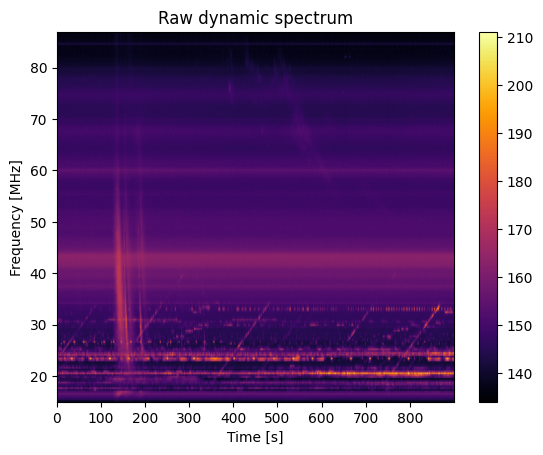

In [14]:
try:
    plotting = importlib.import_module("ecallisto_fits.plotting")
    public = [n for n in dir(plotting) if not n.startswith("_")]
    print("plotting.py exports:", public)

    if hasattr(plotting, "plot_dynamic_spectrum"):
        out = plotting.plot_dynamic_spectrum(ds, title="Raw dynamic spectrum")

        if isinstance(out, tuple):
            if len(out) == 2:
                fig, ax = out
            elif len(out) == 3:
                fig, ax, _ = out
            else:
                raise ValueError(f"plot_dynamic_spectrum returned {len(out)} values, expected 2 or 3.")
        else:
            ax = out
            fig = ax.figure
    else:
        fig, ax = plot_fallback(ds, title="Raw dynamic spectrum")
except ModuleNotFoundError:
    fig, ax = plot_fallback(ds, title="Raw dynamic spectrum")

plt.show()


## 5) Noise reduction

This calls your `noise_reduce_mean_clip` function.
Tune `clip_low` and `clip_high` based on your data.


In [10]:
ds_clean = ef.noise_reduce_mean_clip(
    ds,
    clip_low=-2,
    clip_high=3,
    scale=None,
)

print("clean min/max:", float(ds_clean.data.min()), float(ds_clean.data.max()))

clean min/max: -2.0 3.0


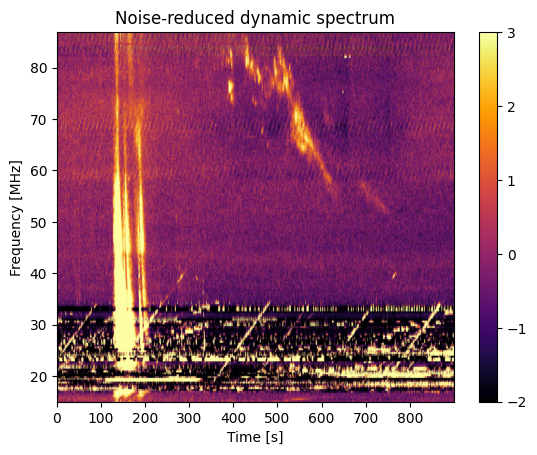

In [15]:
try:
    plotting = importlib.import_module("ecallisto_fits.plotting")

    if hasattr(plotting, "plot_dynamic_spectrum"):
        out = plotting.plot_dynamic_spectrum(ds_clean, title="Noise-reduced dynamic spectrum")

        if isinstance(out, tuple):
            if len(out) == 2:
                fig, ax = out
            elif len(out) == 3:
                fig, ax, _ = out
            else:
                raise ValueError(f"plot_dynamic_spectrum returned {len(out)} values, expected 2 or 3.")
        else:
            ax = out
            fig = ax.figure
    else:
        fig, ax = plot_fallback(ds_clean, title="Noise-reduced dynamic spectrum")

except ModuleNotFoundError:
    fig, ax = plot_fallback(ds_clean, title="Noise-reduced dynamic spectrum")

plt.show()


## 6) Save a figure

Save the last figure to disk.


In [16]:
out_png = DATA_DIR / "quicklook.png"
fig.savefig(out_png, dpi=200, bbox_inches="tight")
print("Saved:", out_png)

Saved: /Users/saan/Downloads/quicklook.png


## 7) Optional: combine files

If you have multiple files, you can combine them.

- Frequency combine: focus 01 + 02 with same station/date/time
- Time combine: consecutive times with same station/date/focus

Adjust the file paths below.


In [13]:
try:
    cb = importlib.import_module("ecallisto_fits.combine")
    public = [n for n in dir(cb) if not n.startswith("_")]
    print("combine.py exports:", public)

    # Example (edit these):
    f1 = DATA_DIR / "file_01.fit.gz"
    f2 = DATA_DIR / "file_02.fit.gz"

    if f1.exists() and f2.exists() and hasattr(cb, "can_combine_frequency") and hasattr(cb, "combine_frequency"):
        if cb.can_combine_frequency(f1, f2):
            ds_cf = cb.combine_frequency(f1, f2)
            print("Combined in frequency:", ds_cf.data.shape)
        else:
            print("Those two files cannot be combined in frequency.")
    else:
        print("Frequency combine example skipped (files missing or functions not present).")

    # Time combine example:
    files = [
        DATA_DIR / "file_t1.fit.gz",
        DATA_DIR / "file_t2.fit.gz",
        DATA_DIR / "file_t3.fit.gz",
    ]

    if all(p.exists() for p in files) and hasattr(cb, "can_combine_time") and hasattr(cb, "combine_time"):
        if cb.can_combine_time(files):
            ds_ct = cb.combine_time(files)
            print("Combined in time:", ds_ct.data.shape)
        else:
            print("Those files cannot be combined in time.")
    else:
        print("Time combine example skipped (files missing or functions not present).")

except ModuleNotFoundError:
    print("ecallisto_fits.combine module not found.")

combine.py exports: ['DynamicSpectrum', 'Iterable', 'Path', 'annotations', 'can_combine_frequency', 'can_combine_time', 'combine_frequency', 'combine_time', 'np', 'parse_callisto_filename', 'read_fits']
Frequency combine example skipped (files missing or functions not present).
Time combine example skipped (files missing or functions not present).
